In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from model import CFTModel, generate_dataset
from baselines import SurvivalModel, PosNegModel

In [2]:
n_samples = 40000
x, c, t, s = generate_dataset(n_samples, noise=.5)

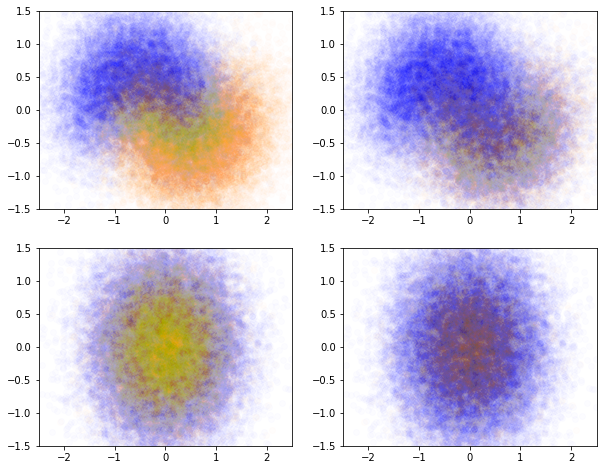

In [3]:
# visualize c (left) and s (right)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i in range(2):

    ax[i, 0].scatter(x[c[:, i] == 0, 2 * i], x[c[:, i] == 0, 2 * i + 1], alpha=.01, c='blue')
    ax[i, 0].scatter(x[c[:, i] == 1, 2 * i], x[c[:, i] == 1, 2 * i + 1], alpha=.01, c='orange')

    ax[i, 1].scatter(x[s[:, i] == 0, 2 * i], x[s[:, i] == 0, 2 * i + 1], alpha=.01, c='blue')
    ax[i, 1].scatter(x[s[:, i] == 1, 2 * i], x[s[:, i] == 1, 2 * i + 1], alpha=.01, c='orange')

    for j in range(2):
        ax[i, j].set_xlim([-2.5, 2.5])
        ax[i, j].set_ylim([-1.5, 1.5])

plt.show()

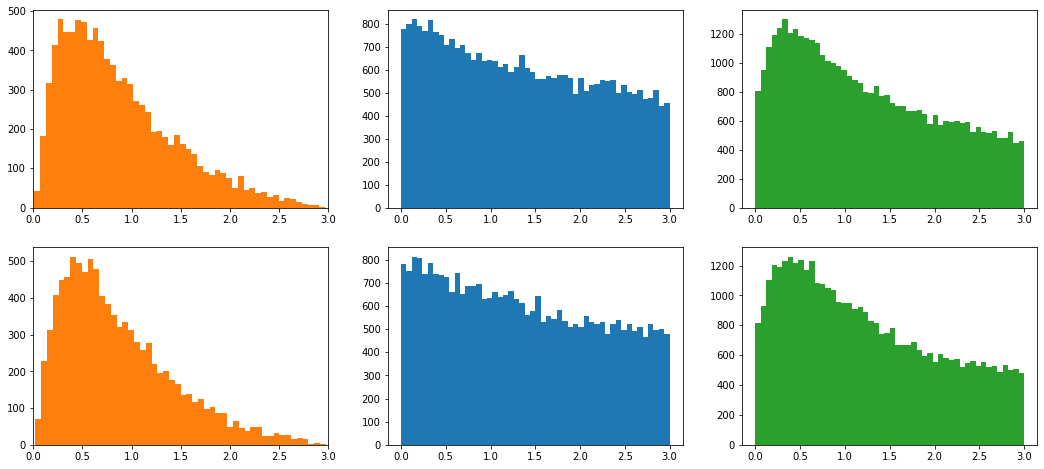

In [4]:
# visualize event times

fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for i in range(2):
    
    ax[i, 0].hist(t[s[:, i] == 1, i], color='C1', bins=50)
    ax[i, 0].set_xlim([0, 3])
    ax[i, 1].hist(t[s[:, i] == 0, i], color='C0', bins=50)
    ax[i, 2].hist(t[:, i], color='C2', bins=50)

plt.show()

In [13]:
# partition into train and validation sets

val_idx = 3 * n_samples // 5
test_idx = 4 * n_samples // 5

x_train = x[:val_idx]
t_train = t[:val_idx]
s_train = s[:val_idx]
c_train = c[:val_idx]

x_val = x[val_idx:test_idx]
t_val = t[val_idx:test_idx]
s_val = s[val_idx:test_idx]
c_val = c[val_idx:test_idx]

x_test = x[test_idx:]
t_test = t[test_idx:]
s_test = s[test_idx:]
c_test = c[test_idx:]

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


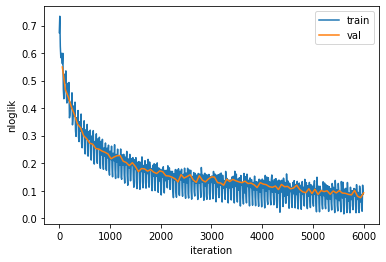

In [41]:
# Run CFT Model

tf.reset_default_graph()

cft_mdl = CFTModel(
    encoder_layer_sizes=(50,),
    decoder_layer_sizes=(50,),
    estimator='gs',
    fpr_likelihood=True,
    fpr=1.,
    prop_fpr=True,
    gs_temperature=.3,
    n_samples=30,
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = cft_mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        100, max_epochs_no_improve=10, learning_rate=3e-4,
        verbose=False)
    c_pred_cft, t_pred_cft = cft_mdl.predict_c_and_t(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

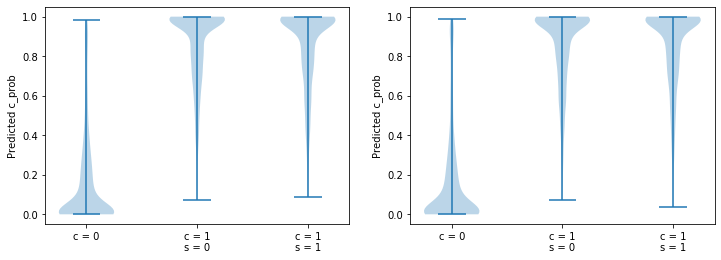

In [42]:
# Visualize CFT Predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].violinplot([
        c_pred_cft[c_test[:, i] == 0, i],
        c_pred_cft[(c_test[:, i] == 1) & (s_test[:, i] == 0), i],
        c_pred_cft[(c_test[:, i] == 1) & (s_test[:, i] == 1), i]])
    ax[i].set_xticks([1, 2, 3])
    ax[i].set_xticklabels(['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
    ax[i].set_ylabel('Predicted c_prob')

plt.show()

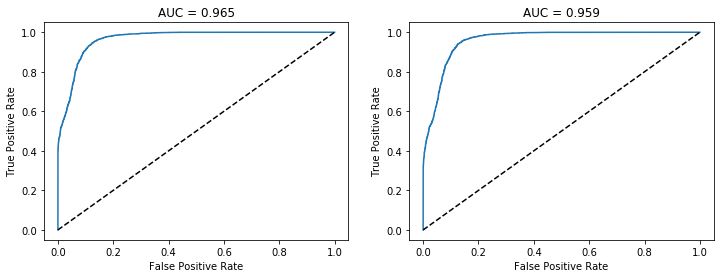

In [43]:
# CFT performance in predicting c

from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    fpr, tpr, _ = roc_curve(c_test[:, i], c_pred_cft[:, i])
    ax[i].plot(fpr, tpr)
    ax[i].plot([0, 1], [0, 1], 'k--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title('AUC = %.3f' % roc_auc_score(c_test[:, i], c_pred_cft[:, i]))

plt.show()

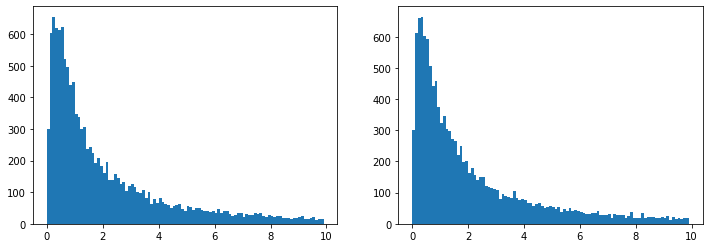

In [9]:
# CFT event time predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].hist(t_pred_cft[:, i].flatten(), bins=np.arange(100) / 10)

plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


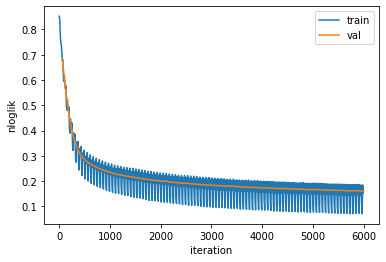

In [14]:
# Train deep survival model (not conditional)

tf.reset_default_graph()

surv_mdl = SurvivalModel(
    decoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = surv_mdl.train(
        sess,
        [x_train, c_train, t_train, s_train],
        [x_val, c_val, t_val, s_val],
        100, max_epochs_no_improve=10, learning_rate=1e-3,
        verbose=False)
    t_pred_surv = surv_mdl.predict(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


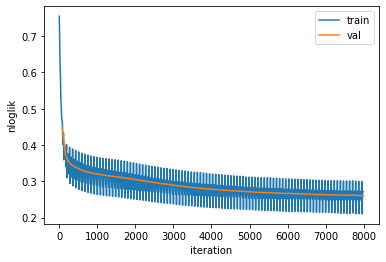

In [16]:
# Train MLP to predict s directly

tf.reset_default_graph()

posneg_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = posneg_mdl.train(
        sess, [x_train, s_train], [x_val, s_val],
        100, max_epochs_no_improve=10, learning_rate=1e-3,
        verbose=False)
    s_pred_posneg = posneg_mdl.predict(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


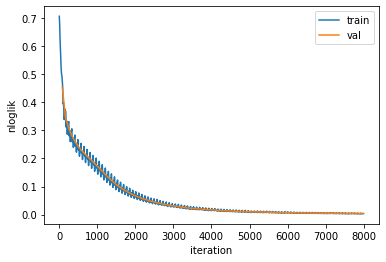

In [17]:
# Train MLP to predict c directly (to see optimal classification performance)

tf.reset_default_graph()

c_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = c_mdl.train(
        sess, [x_train, c_train], [x_val, c_val],
        100, max_epochs_no_improve=10, learning_rate=1e-3,
        verbose=False)
    c_pred_posneg = c_mdl.predict(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

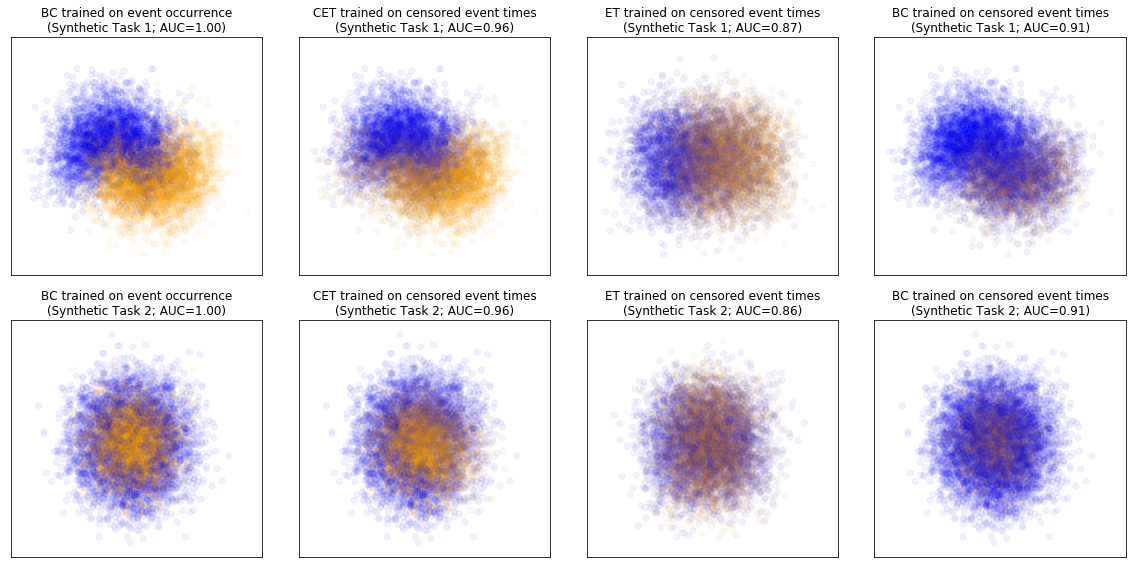

In [44]:
# Compare results between models

from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('BuOr', ['blue', 'orange'], N=100)

def time_to_prob(x):
    sorted_pos = {v: pos for pos, v in enumerate(sorted(x))}
    return 1 - np.array([sorted_pos[v] / len(x) for v in x])

def t_to_prob(x):
    return np.stack([time_to_prob(arr) for arr in x.T]).T

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)

for i in range(2):

    ax[i, 0].scatter(x_test[:, 2 * i], x_test[:, 2 * i + 1], c=c_pred_posneg[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 0].set_title('BC trained on event occurrence\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], c_pred_posneg[:, i])), fontsize=12)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].scatter(x_test[:, 2 * i], x_test[:, 2 * i + 1], c=c_pred_cft[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 1].set_title('CET trained on censored event times\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], c_pred_cft[:, i])), fontsize=12)
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    
    t_prob_surv = t_to_prob(t_pred_surv)
    ax[i, 2].scatter(x_test[:, 2 * i], x_val[:, 2 * i + 1], c=t_prob_surv[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 2].set_title('ET trained on censored event times\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], t_prob_surv[:, i])), fontsize=12)
    ax[i, 2].set_xticks([])
    ax[i, 1].set_yticks([])
    
    ax[i, 3].scatter(x_test[:, 2 * i], x_test[:, 2 * i + 1], c=s_pred_posneg[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 3].set_title('BC trained on censored event times\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], s_pred_posneg[:, i])), fontsize=12)
    ax[i, 3].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()
plt.savefig('/Users/mme/Downloads/fig1.pdf')
plt.show()

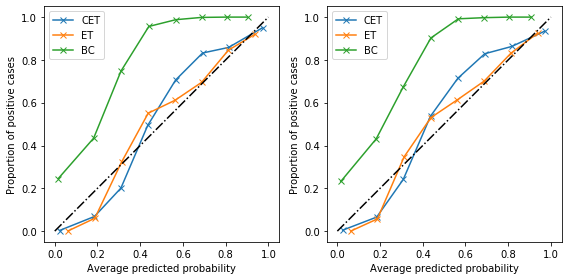

In [47]:
# Visualize calibration

from sklearn.calibration import calibration_curve

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i in range(2):
    pt, pp = calibration_curve(c_test[:, i], c_pred_cft[:, i], normalize=False, n_bins=8)
    ax[i].plot(pp, pt, 'x-', label='CET')
    pt, pp = calibration_curve(c_test[:, i], t_prob_surv[:, i], normalize=False, n_bins=8)
    ax[i].plot(pp, pt, 'x-', label='ET')
    pt, pp = calibration_curve(c_test[:, i], s_pred_posneg[:, i], normalize=False, n_bins=8)
    ax[i].plot(pp, pt, 'x-', label='BC')
    ax[i].plot([0, 1], [0, 1], 'k-.')
    ax[i].legend()
    ax[i].set_xlabel('Average predicted probability')
    ax[i].set_ylabel('Proportion of positive cases')

plt.tight_layout()
plt.savefig('/Users/mme/Downloads/fig2.pdf')